# Predictive Analytics: PM2.5 Pollutant Value Prediction to Monitor Air Quality and Air Pollution Levels. 
*   Author: Millata Tasyakhanifa
*   Username: millatasyaa
*   Email: millatatasyakhanifa@gmail.com


#Pendahuluan
##### Proyek yang saya kerjakan berkaitan dengan isu kesehatan dan lingkungan yaitu memprediksi nilai PM2.5 pada 30 jam ke depan. PM2.5 merupakan salah satu polutan berbahaya yang dapat mencemari udara. Proyek ini dibuat untuk memenuhi Submission 1 pada course Machine Learning Terapan Dicoding.

#1. Import Library

In [ ]:
# Library untuk mengolah data
import pandas as pd
import numpy as np
import os

# Library untuk data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Library untuk membuat model
import tensorflow as tf
from keras.layers import Dense, LSTM

#2. Prepare Dataset

In [ ]:
# Membuat folder .kaggle pada folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin file kaggle.json ke dalam folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset menggunakan Kaggle CLI
!kaggle datasets download bappekim/air-pollution-in-seoul

 41% 8.00M/19.7M [00:00<00:00, 82.2MB/s]
100% 19.7M/19.7M [00:00<00:00, 96.8MB/s]


In [ ]:
# Mengekstrak berkas air-pollution-in-seoul.zip
!unzip /content/air-pollution-in-seoul.zip

Archive:  /content/air-pollution-in-seoul.zip
  inflating: AirPollutionSeoul/Measurement_summary.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_item_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_station_info.csv  


#3. Data Understanding

3.1 Membaca Dataset dan Menampilkan 5 Data Pertama

In [ ]:
df = pd.read_csv('/content/AirPollutionSeoul/Measurement_summary.csv')
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


3.2 Menampilkan Keterangan Kolom Dataset

In [ ]:
# Menampilkan ringkasan singkat dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Measurement date  647511 non-null  object 
 1   Station code      647511 non-null  int64  
 2   Address           647511 non-null  object 
 3   Latitude          647511 non-null  float64
 4   Longitude         647511 non-null  float64
 5   SO2               647511 non-null  float64
 6   NO2               647511 non-null  float64
 7   O3                647511 non-null  float64
 8   CO                647511 non-null  float64
 9   PM10              647511 non-null  float64
 10  PM2.5             647511 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 54.3+ MB


In [ ]:
# Menampilkan shape data
df.shape

(647511, 11)

In [ ]:
# Menampilkan jumlah rows dan columns
rows = df.shape[0]
columns = df.shape[1]

print("Number of rows: " + str(rows))
print("Number of columns: " + str(columns))

Number of rows: 647511
Number of columns: 11


In [ ]:
# Menampilkan kolom
df.columns

Index(['Measurement date', 'Station code', 'Address', 'Latitude', 'Longitude',
       'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object')

In [ ]:
# Mengecek duplicate data
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
647506    False
647507    False
647508    False
647509    False
647510    False
Length: 647511, dtype: bool

In [ ]:
# Mengecek jumlah duplicate data
sum(df.duplicated())

0

In [ ]:
# Mengecek jumlah missing value pada setiap kolom
df.isnull().sum()

Measurement date    0
Station code        0
Address             0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64

In [ ]:
# Mengecek jumlah unique value dari setiap kolom
df.nunique()

Measurement date    25906
Station code           25
Address                25
Latitude               25
Longitude              25
SO2                   186
NO2                   132
O3                    253
CO                    172
PM10                  551
PM2.5                 333
dtype: int64

In [ ]:
# menampilkan statistik dasar setiap kolom
df.describe()

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


3.3 Memvisualisasikan Data

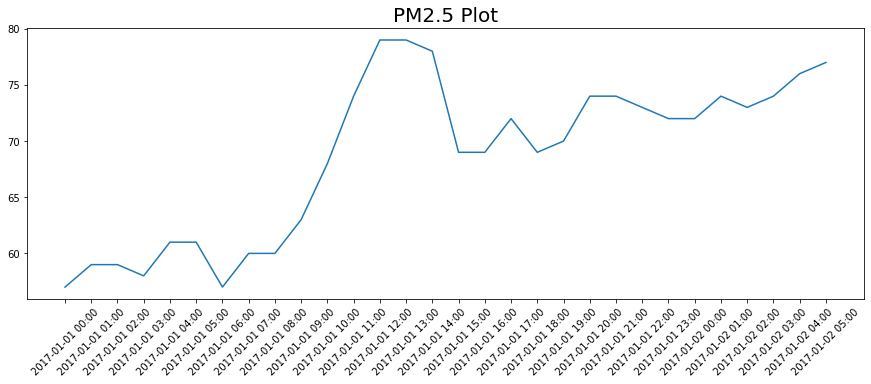

In [ ]:
# Membuat dan menampilkan plot untuk menampilkan nilai dari PM2.5
dates = df['Measurement date'].values[:30]
pollutan = df['PM2.5'].values[:30]
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, pollutan)
plt.xticks(rotation=45)
plt.title('PM2.5 Plot',fontsize=20);

# 4. Data Preparation

4.1 Teknik Feature selection: Menghapus unnecessary column

In [ ]:
# Menghapus kolom Station code, Address, Latitude, Longitude, SO2, NO2, O3, CO, PM10, Measurement date
df = df.drop(['Station code', 'Address', 'Latitude', 'Longitude','SO2', 'NO2', 'O3', 'CO', 'PM10','Measurement date'], axis=1)

4.2 Teknik data Cleaning: Menghapus Outliers pada kolom PM2.5

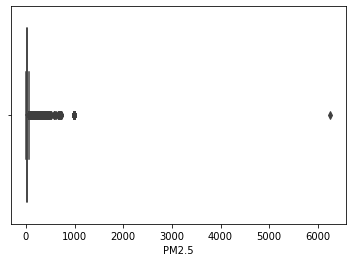

In [ ]:
# Mencari outliers
sns.boxplot(x=df['PM2.5'])

In [ ]:
# Menghapus outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

In [ ]:
# Cek shape dataset setelah menghapus outliers
df.shape

(616047, 1)

4.3 Teknik Train Test Split untuk membagi data

In [ ]:
# Membagi data menjadi 90% data trening dan 10% data testing
values = df.values
train, test = train_test_split(values, test_size = 0.1, random_state = 123, shuffle = False)

In [ ]:
# Menampilkan jumlah data train
train.shape

(554442, 1)

In [ ]:
# Menampilkan jumlah data test
test.shape

(61605, 1)

4.4 Teknik data transforms: Scaling Nilai PM2.5 Menggunakan MinMaxScaler

In [ ]:
# Scaling data
min_max_scaler = MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(train)
scaled_test = min_max_scaler.fit_transform(test)

In [ ]:
# Menampilkan data yang sudah di scaling
scaled_train

array([[0.93548387],
       [0.96774194],
       [0.96774194],
       ...,
       [0.74193548],
       [0.64516129],
       [0.62903226]])

In [ ]:
# Membuat generator menggunakan TimeseriesGenerator
# Menentukan berapa jam yang ingin diprediksi di masa depan
# Proyek ini akan memprediksi PM2.5 pada 30 jam ke depan
n_input = 30
n_feature = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=128)

In [ ]:
# Membuat test_generator untuk digunakan pada saat prediksi menggunakan model terbaik
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length = n_input, batch_size=128)

#5. Membuat Model

5.1 Model LSTM

In [ ]:
# Membuat model LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, activation="relu", return_sequences=True, input_shape=(n_input, n_feature)),
  tf.keras.layers.LSTM(60, activation="relu", return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
# Menampilkan summary dari model yang dibuat
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 60)            26640     
                                                                 
 dense (Dense)               (None, 30, 30)            1830      
                                                                 
 dense_1 (Dense)             (None, 30, 10)            310       
                                                                 
 dense_2 (Dense)             (None, 30, 1)             11        
                                                                 
Total params: 39,191
Trainable params: 39,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling model 
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Training model dengan 10 epochs
history = model.fit(generator, 
                    epochs=10)

Epoch 1/10
4332/4332 [==============================] - 285s 65ms/step - loss: 0.0199 - mae: 0.1576
Epoch 2/10
4332/4332 [==============================] - 284s 65ms/step - loss: 0.0167 - mae: 0.1407
Epoch 3/10
4332/4332 [==============================] - 284s 65ms/step - loss: 0.0164 - mae: 0.1387
Epoch 4/10
4332/4332 [==============================] - 283s 65ms/step - loss: 0.0163 - mae: 0.1379
Epoch 5/10
4332/4332 [==============================] - 283s 65ms/step - loss: 0.0162 - mae: 0.1374
Epoch 6/10
4332/4332 [==============================] - 288s 67ms/step - loss: 0.0161 - mae: 0.1369
Epoch 7/10
4332/4332 [==============================] - 287s 66ms/step - loss: 0.0161 - mae: 0.1366
Epoch 8/10
4332/4332 [==============================] - 290s 67ms/step - loss: 0.0160 - mae: 0.1363
Epoch 9/10
4332/4332 [==============================] - 284s 66ms/step - loss: 0.0160 - mae: 0.1361
Epoch 10/10
4332/4332 [==============================] - 286s 66ms/step - loss: 0.0160 - mae: 0.1358

5.2 Model CNN

In [ ]:
# Membuat model CNN
model_CNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu",
                               input_shape=(n_input, n_feature)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

In [ ]:
# Menampilkan summary dari model yang dibuat
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                30784     
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
# Compiling model 
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model_CNN.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Training model dengan 10 epochs
history_CNN = model_CNN.fit(generator, 
                            epochs=10)

Epoch 1/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0134 - mae: 0.1222
Epoch 2/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0094 - mae: 0.1021
Epoch 3/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0084 - mae: 0.0951
Epoch 4/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0078 - mae: 0.0907
Epoch 5/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0074 - mae: 0.0875
Epoch 6/10
4332/4332 [==============================] - 30s 7ms/step - loss: 0.0071 - mae: 0.0851
Epoch 7/10
4332/4332 [==============================] - 30s 7ms/step - loss: 0.0068 - mae: 0.0831
Epoch 8/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0066 - mae: 0.0815
Epoch 9/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0064 - mae: 0.0800
Epoch 10/10
4332/4332 [==============================] - 29s 7ms/step - loss: 0.0062 - mae: 0.0787


5.3 Mencoba Membuat Prediksi Menggunakan Model CNN
- Model CNN dipilih karena menghasilkan nilai loss dan nilai MAE yang lebih kecil dibandingkan dengan model LSTM

In [ ]:
model_CNN.evaluate(test_generator, verbose=0)

[0.005914489738643169, 0.07666974514722824]

In [ ]:
predictions = model_CNN.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predictions.shape[0]

61575

In [ ]:
predictions

array([[0.1615516 ],
       [0.16204171],
       [0.18993193],
       ...,
       [0.3045644 ],
       [0.30073372],
       [0.29798907]], dtype=float32)

#6. Evaluasi Model

6.1 Membuat Plot Loss dan MAE Selama Proses Training untuk Model LSTM

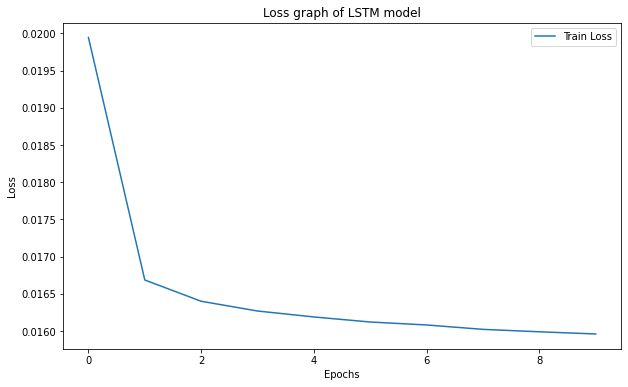

In [ ]:
# Menampilkan plot loss pada proses training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss graph of LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

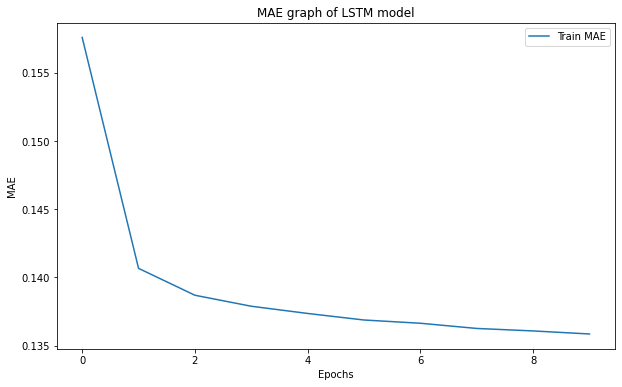

In [ ]:
# Menampilkan plot MAE pada proses training
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.title('MAE graph of LSTM model')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

6.2 Membuat Plot Loss dan MAE Selama Proses Training untuk Model CNN

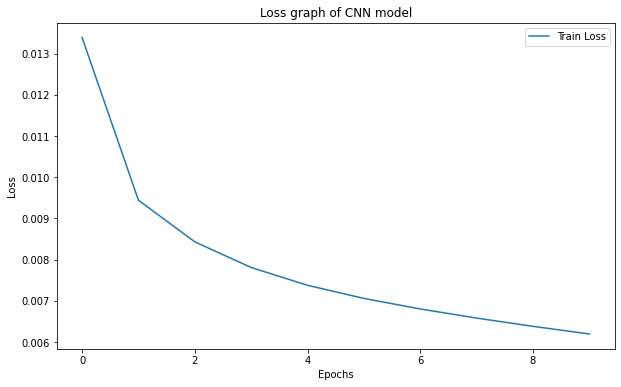

In [ ]:
# Menampilkan plot loss pada proses training
plt.figure(figsize=(10, 6))
plt.plot(history_CNN.history['loss'], label='Train Loss')
plt.title('Loss graph of CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

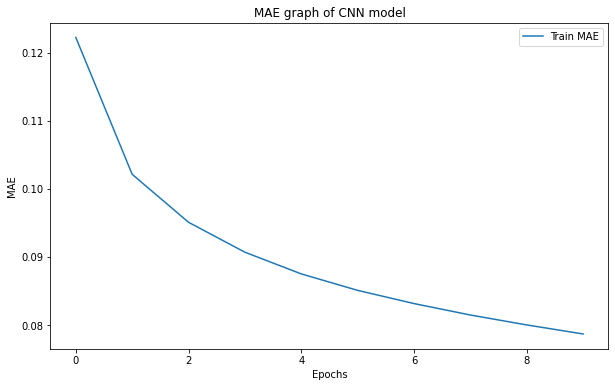

In [ ]:
# Menampilkan plot MAE pada proses training
plt.figure(figsize=(10, 6))
plt.plot(history_CNN.history['mae'], label='Train MAE')
plt.title('MAE graph of CNN model')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

6.3 Membuat Plot untuk Hasil Prediksi Menggunakan Model CNN 

In [ ]:
test[:,1:][n_input:]

array([], shape=(61575, 0), dtype=float64)

In [ ]:
df_predict = pd.concat([pd.DataFrame(predictions), pd.DataFrame(test[:,1:][n_input:])], axis=1)

In [ ]:
rev_transform=min_max_scaler.inverse_transform(df_predict)

In [ ]:
rev_transform

array([[ 9.016199],
       [ 9.046586],
       [10.77578 ],
       ...,
       [17.882992],
       [17.645489],
       [17.47532 ]], dtype=float32)

In [ ]:
df_final = df[predictions.shape[0]*-1:]
df_final.count()

PM2.5    61575
dtype: int64

In [ ]:
df_final['PM2.5_predict'] = rev_transform[:,0]
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PM2.5,PM2.5_predict
582855,8.0,9.016199
582856,13.0,9.046586
582857,14.0,10.775780
582858,12.0,10.447958
582859,9.0,10.626148
...,...,...
647506,17.0,17.407013
647507,19.0,17.314137
647508,17.0,17.882992
647509,18.0,17.645489


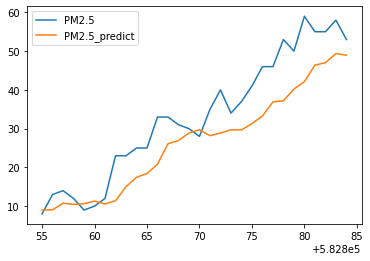

In [ ]:
df_final[['PM2.5','PM2.5_predict']][:30].plot()

# Penutup
Pembuatan model untuk memprediksi data PM2.5 telah selesai. Model ini diharapkan dapat membantu memprediksi data PM2.5 pada 30 jam ke depan karena PM2.5 merupakan salah satu polutan berbahaya yang dapat mencemari udara dan mempengaruhi kesehatan manusia. Selain itu, beberapa pengembangan dapat dilakukan untuk membuat model ini menjadi lebih baik. Pengembangan tersebut diantaranya yaitu membuat arsitektur model LSTM dan model CNN yang lebih kompleks dengan menambahkan layer pada model LSTM dan model CNN yang sudah dibuat.  

# Referensi




*   Dokumentasi Matplotlib:https://matplotlib.org
*   Dokumentasi Seaborn:https://seaborn.pydata.org
*   Dokumentasi Tensorflow:https://www.tensorflow.org
*   Dataset:https://www.kaggle.com/bappekim/air-pollution-in-seoul
*   Referensi lainnya:
*   https://github.com/fahmij8/ML-Exercise/blob/main/MLT-1/MLT_Proyek_Submission_1.ipynb
*   https://youtu.be/4FmVIpcwl4k






